# Learning From A Learning User For Optimal Recommendations

In [1]:
from lib.AES import AES
from lib.DBGD import DBGD
from lib.SMD import SMD
import numpy as np
import matplotlib.pyplot as plt
from Users.LearningUsers import LinUser
SEED = 666
np.random.seed(SEED)

## Figure 2 Replication

In [2]:
d = 5  # Feature Dimension
T = 10000  # Time Horizon
T0 = 1500  # Exploration steps
delta = 0.2
gamma = 0.1 # User learning rate
cut_thres = 0.99
learning = True

### Problem
In general, I failed to replicate Figure 2 from the paper, since I realized that
when $\gamma > 0$, the eigenvalue will not converge.

C:\Users\yuwei\Desktop\BanditLib\Users\LearningUsers.py:9: RuntimeWarning: invalid value encountered in divide
  return length * x / np.linalg.norm(x)


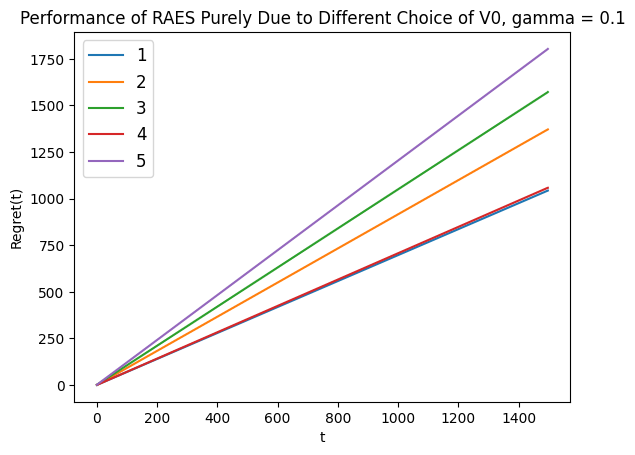

In [3]:
for scale in range(1, 6, 1):
    learning_user = LinUser(feature_dim=d, gamma = gamma, V0=scale * np.identity(n=d))
    aes = AES(feature_dim=d)
    aes_regret = []
    learning_user.reset()
    aes.reset()
    aes.simulate(user=learning_user, T=T, T0=T0, delta=delta, cut_thres=cut_thres, verbose=False, learning = learning)
    aes_regret.append(np.cumsum(aes.regret))
    plt.plot(aes_regret[-1], label= scale)

plt.xlabel("t")
plt.ylabel("Regret(t)")
plt.title("Performance of RAES Purely Due to Different Choice of V0, gamma = 0.1")
plt.legend(fontsize=12)
plt.show()

When we have a perfect learning user, $\gamma = 0.0$, we should expect more informative prior, less cumulative regret.
However, the performance of the RAES algorithm is not stable.

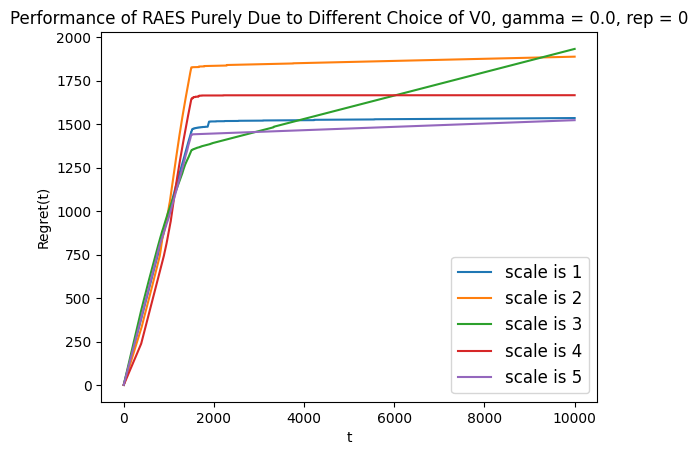

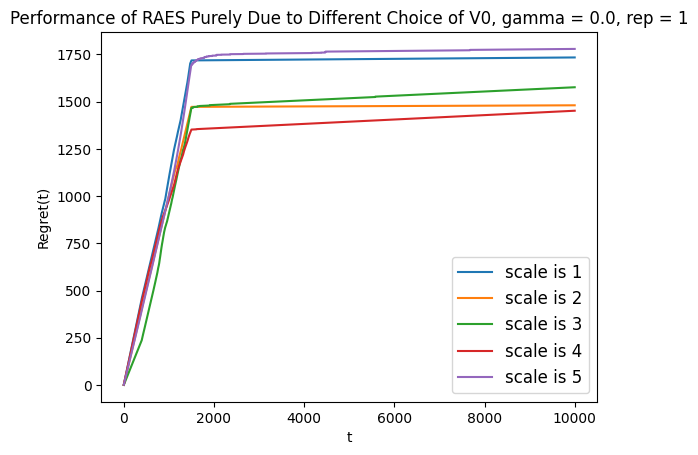

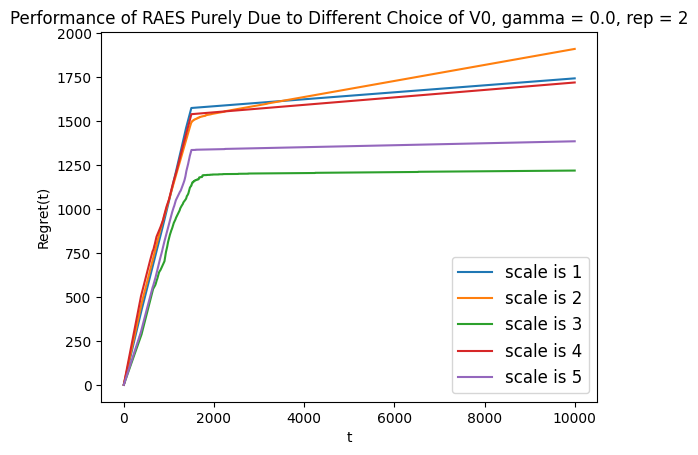

In [4]:
for rep in range(3):
    for scale in range(1, 6, 1):
        learning_user = LinUser(feature_dim=d, gamma = 0.0, V0=scale * np.identity(n=d))
        aes = AES(feature_dim=d)
        aes_regret = []
        learning_user.reset()
        aes.reset()
        aes.simulate(user=learning_user, T=T, T0=T0, delta=delta, cut_thres=cut_thres, verbose=False, learning = learning)
        aes_regret.append(np.cumsum(aes.regret))
        plt.plot(aes_regret[-1], label= f"scale is {scale}")

    plt.xlabel("t")
    plt.ylabel("Regret(t)")
    plt.title(f"Performance of RAES Purely Due to Different Choice of V0, gamma = 0.0, rep = {rep}")
    plt.legend(fontsize=12)
    plt.show()

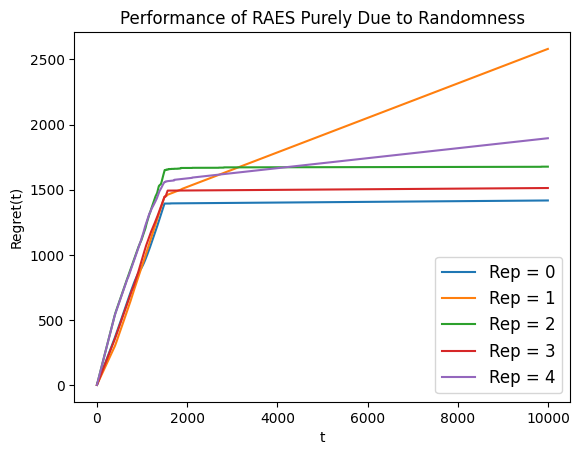

In [5]:
for rep in range(5):
    learning_user = LinUser(feature_dim=d, gamma = 0.0, V0=1.0 * np.identity(n=d))
    aes = AES(feature_dim=d)
    aes_regret = []
    learning_user.reset()
    aes.reset()
    aes.simulate(user=learning_user, T=T, T0=T0, delta=delta, cut_thres=cut_thres, verbose=False, learning = learning)
    aes_regret.append(np.cumsum(aes.regret))
    plt.plot(aes_regret[-1], label= f"Rep = {rep}")

plt.xlabel("t")
plt.ylabel("Regret(t)")
plt.title("Performance of RAES Purely Due to Randomness")
plt.legend(fontsize=12)
plt.show()

# DBGD algorithm with different user learning rate

In general, I realized that the performance of DBGD algorithm is stable with respect to different choice
of learning rate and $V_0$. However, in general, I don't observe $O(T^{\frac{1}{2} + \gamma})$

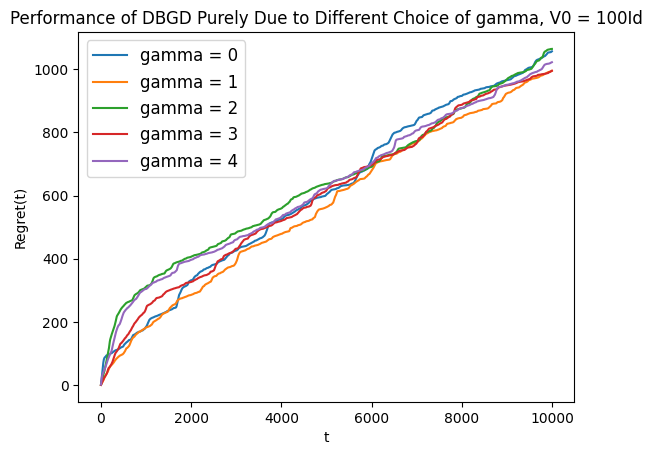

In [6]:
for g in range(0, 5, 1):
    learning_user = LinUser(feature_dim=d, gamma = g*0.1, V0 = 100 * np.identity(n=d))
    dbgd = DBGD(feature_dim=d)
    dbgd_regret = []
    learning_user.reset()
    dbgd.simulate(user=learning_user, T=T, learning = learning)
    dbgd_regret.append(np.cumsum(dbgd.regret))
    plt.plot(dbgd_regret[-1], label= f"gamma = {g}")

plt.xlabel("t")
plt.ylabel("Regret(t)")
plt.legend(fontsize=12)
plt.title("Performance of DBGD Purely Due to Different Choice of gamma, V0 = 100Id")
plt.show()

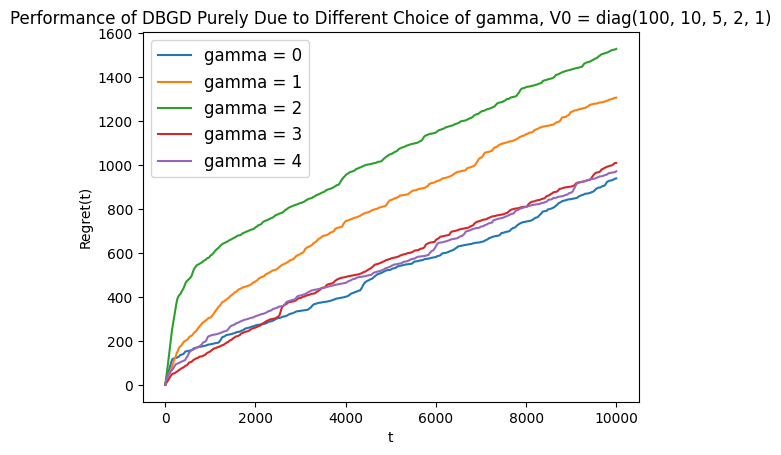

In [7]:
for g in range(0, 5, 1):
    learning_user = LinUser(feature_dim=d, gamma = g*0.1, V0 = np.diag([100.0, 10.0, 5.0, 2.0, 1.0]))
    dbgd = DBGD(feature_dim=d)
    dbgd_regret = []
    learning_user.reset()
    dbgd.simulate(user=learning_user, T=T, learning = learning)
    dbgd_regret.append(np.cumsum(dbgd.regret))
    plt.plot(dbgd_regret[-1], label= f"gamma = {g}")

plt.xlabel("t")
plt.ylabel("Regret(t)")
plt.legend(fontsize=12)
plt.title("Performance of DBGD Purely Due to Different Choice of gamma, V0 = diag(100, 10, 5, 2, 1)")
plt.show()

# Noise Comparison Based Stochastic Mirror Descent

I haven't managed to achieve the sublinear regret. I don't know which part is wrong.

We know that $f(x) = -\sum^m_{i = 1}\text{log}(b_i - a^T_ix)$ is a family of self-concordant function.
We choose m = 1, $b_i = 2, a_i = 1$.

$
\begin{align*}
    R(a) & = -\text{log}(2 - 1^Ta)\\
    R_t(a) & = -\text{log}(2 - 1^Ta) + \frac{\lambda \eta}{2} \sum^{t}_{i = 1} \|a - a_i\|^2 + \mu \|a\|^2\\
    \nabla R_t(a) & = \frac{1}{2 - 1^Ta} + \lambda \eta \sum^t_{i = 1}(a - a_i) + 2 * \mu * a\\
    \nabla^2 R_t(a) & = \frac{1 1^T}{(2 - 1^Ta)^2} + (\lambda \eta t + 2\mu) I
\end{align*}
$

<code>

    for t in range(1, T, 1):
        left = self.alpha[t-1, :]
        ut = self.gen_rand_direction()
        H = self.hessian(left, t)
        G = self.gradient(left, t)

        right = norm2(left + np.linalg.inv(self.rt_square_root(H)) @ ut)
        right_score, winner, _ = user.get_winner(left, right, learning = learning)
        gt = right_score * self.d * self.rt_square_root(H)@ut
        new = np.linalg.inv(H) @ (G - self.eta * gt)
        self.alpha[t, :] = norm2(new)
        user.get_reward(winner)
        self.regret.append(1 - np.dot(user.theta_star, winner))
</code>

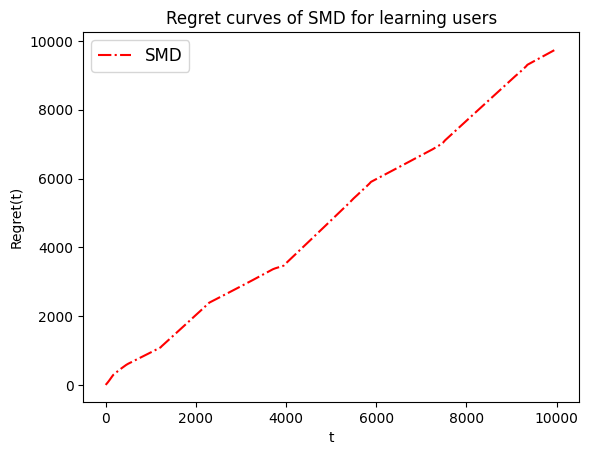

In [9]:
d = 2
user = LinUser(feature_dim=d, V0=1.0 * np.identity(n=d))
# algorithm initialization
smd = SMD(feature_dim=d)
regret = []
user.reset()
smd.simulate(user=user, T=T, plot=False)

# visualize result
regret.append(np.cumsum(smd.regret))
plt.plot(regret[-1], 'r-.', label='SMD')
plt.title('Regret curves of SMD for learning users')
plt.xlabel("t")
plt.ylabel("Regret(t)")
plt.legend(fontsize=12)
plt.show()